In [1]:
from qiskit_ibm_provider import IBMProvider
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from helper import circuit_runtime_in_ms

# Parameters

In [2]:
no_dd_job_id = 'cgpketvtpqa5eaoad6fg'
dd_job_id = 'cgpkjmemln59sp44skt0'

snooper_qubits = (1, 4, 6)
victim_qubits = (3, 5)
ibm_backend_name = 'ibm_nairobi'

max_circuit_depth = 50
cnot_vals = list(range(20))
no_of_circuits_per_cnot_val = 60

# IBM Backend

In [3]:
provider = IBMProvider()
backend = provider.get_backend(ibm_backend_name)

In [4]:
no_dd_job = provider.backend.retrieve_job(no_dd_job_id)
dd_job = provider.backend.retrieve_job(dd_job_id)

In [5]:
no_dd_job_counts = no_dd_job.result().get_counts()
dd_job_counts = dd_job.result().get_counts()

# Analysis

## Bucket 000 count per cnot exp and calc mean

5 buckets random - choose a median and plot

In [6]:
no_of_buckets = 5

In [7]:
no_dd_medians = []
dd_medians = []

for i in cnot_vals:
    no_dd_buckets = [[] for i in range(no_of_buckets)]
    dd_buckets = [[] for i in range(no_of_buckets)]
    start_index = i*no_of_circuits_per_cnot_val
    end_index = (i+1)*no_of_circuits_per_cnot_val
    # bucketize 0 counts
    for j, index in enumerate(np.random.permutation(np.arange(start_index, end_index))):
        bucket_index = j % no_of_buckets
        no_dd_buckets[bucket_index].append(no_dd_job_counts[index]['0'*len(snooper_qubits)])
        dd_buckets[bucket_index].append(dd_job_counts[index]['0'*len(snooper_qubits)])
    # calc mean and combined median
    no_dd_means = []
    dd_means = []
    for bucket in no_dd_buckets:
        no_dd_means.append(np.mean(np.array(no_dd_buckets)))
        dd_means.append(np.mean(np.array(dd_buckets)))
    no_dd_median = np.median(np.array(no_dd_means))
    dd_median = np.median(np.array(dd_means))
    no_dd_medians.append(no_dd_median)
    dd_medians.append(dd_median)
    

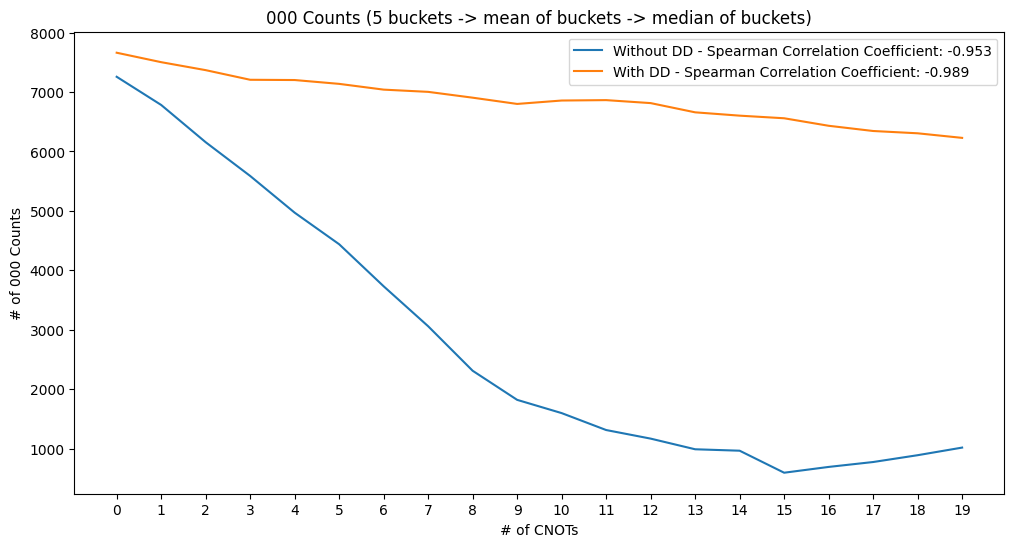

In [8]:
# create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# plot the first line
corr, p_val = spearmanr(cnot_vals, no_dd_medians)
ax.plot(cnot_vals, no_dd_medians, label=f"Without DD - Spearman Correlation Coefficient: {corr:.3f}")

# plot the second line
corr, p_val = spearmanr(cnot_vals, dd_medians)
ax.plot(cnot_vals, dd_medians, label=f"With DD - Spearman Correlation Coefficient: {corr:.3f}")


# corr, p_val = spearmanr(no_dd_medians, dd_medians)
# plt.text(0.7, -0.2, f"Spearman Correlation Coefficient: {corr:.3f}",
#          verticalalignment='bottom', horizontalalignment='right',
#          transform=ax.transAxes, fontsize=10, bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

# set the title and axis labels
ax.set_title('000 Counts (5 buckets -> mean of buckets -> median of buckets)')
ax.set_xlabel('# of CNOTs')
ax.set_ylabel('# of 000 Counts')
ax.set_xticks(cnot_vals)

# add a legend
ax.legend()

# show the plot
plt.show()

## Circuit duration vs 0 count - scatter plot

In [9]:
no_dd_job_circs = no_dd_job.circuits()
dd_job_circs = dd_job.circuits()

In [10]:
no_dd_circuit_runtime_in_ms = []
no_dd_000_counts = []

dd_circuit_runtime_in_ms = []
dd_000_counts = []

for i in range(len(no_dd_job_circs)):
    no_dd_circuit_runtime_in_ms.append(circuit_runtime_in_ms(no_dd_job_circs[i], backend))
    no_dd_000_counts.append(no_dd_job_counts[i]['000'])
    dd_circuit_runtime_in_ms.append(circuit_runtime_in_ms(dd_job_circs[i], backend))
    dd_000_counts.append(dd_job_counts[i]['000'])


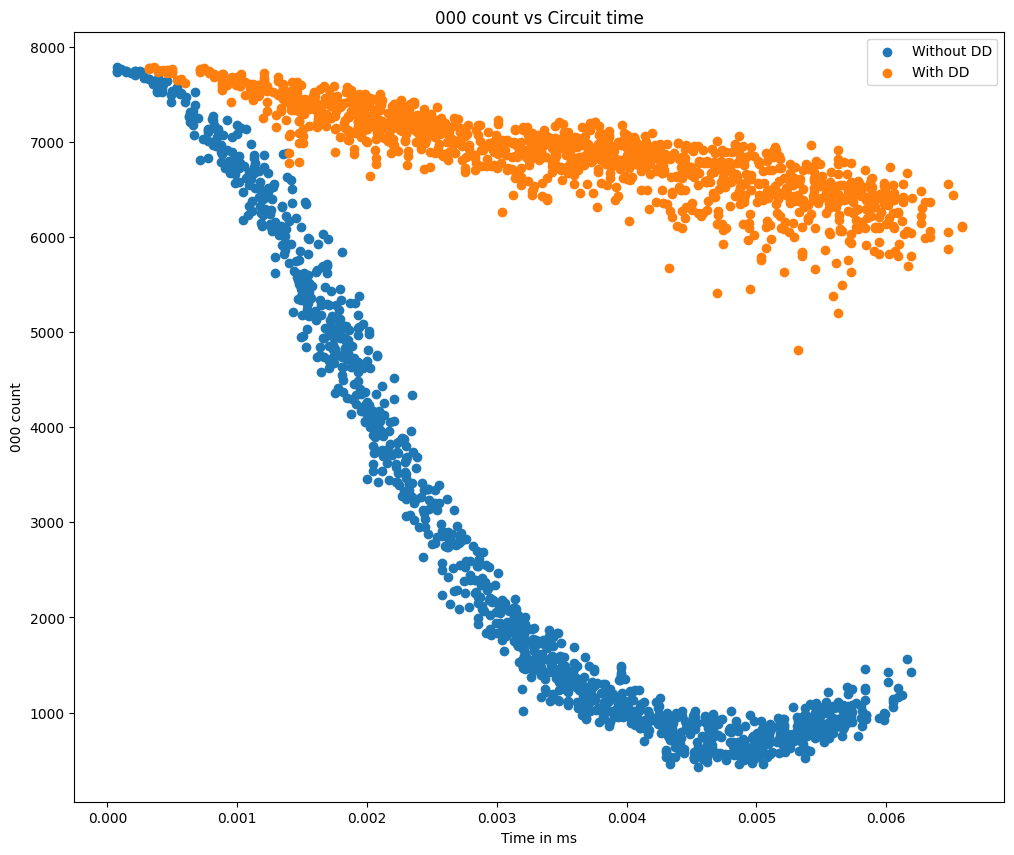

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))



# create scatter plots
ax.scatter(no_dd_circuit_runtime_in_ms, no_dd_000_counts, label='Without DD')
ax.scatter(dd_circuit_runtime_in_ms, dd_000_counts, label='With DD')

# add axis labels and title
plt.xlabel('Time in ms')
plt.ylabel('000 count')
plt.title('000 count vs Circuit time')

# add legend
plt.legend()

# show the plot
plt.show()